### Evaluating a trained model on the Test Set

In [1]:
# This notebook was executed on Kaggle Kernels
!rm -rf pytorch-slim-cnn
!git clone https://github.com/gtamba/pytorch-slim-cnn
!mv pytorch-slim-cnn/* .

Cloning into 'pytorch-slim-cnn'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 46 (delta 19), reused 40 (delta 13), pack-reused 0
Unpacking objects: 100% (46/46), done.


### Loading a Pre-trained Model

In [2]:
import torch
from datasets import CelebADataset
from slimnet import SlimNet
from torch import nn
from torch import optim
from torchvision import transforms


In [3]:
model = SlimNet.load_pretrained('models/celeba_20.pth')
transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

test_dataset = CelebADataset(transform=transform,split='test')
label_ids = test_dataset.labels.columns[1:]

### Calculate average classification accuracy as well as classification accuracy per class on the Test Set

In [4]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2)

correct = 0
total = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
total_classwise = torch.zeros([len(label_ids)]).to(device)
correct_classwise = torch.zeros([len(label_ids)]).to(device)
model.to(device)

with torch.no_grad():
            model.eval()
            for batch_idx, (images,labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                logits = model.forward(images)
                sigmoid_logits = torch.sigmoid(logits)
                predictions = sigmoid_logits > 0.5
                total += labels.size(0) * labels.size(1)
                total_classwise += labels.size(0)
                matches = (labels.type(predictions.type()) == predictions)
                correct += matches.sum().item()
                correct_classwise += matches.sum(dim=0).type(total_classwise.type())
                
print(f"Average Class Accuracy on Test: {100 * correct / total}")
print("")

total_classwise = total_classwise.cpu().detach().numpy()
correct_classwise = correct_classwise.cpu().detach().numpy()
class_accuracies = correct_classwise / total_classwise * 100

for idx, score in enumerate(class_accuracies):

    print(f"Accuracy for {label_ids[idx]} : {score}")

Average Class Accuracy on Test: 89.84595731890592

Accuracy for 5_o_Clock_Shadow : 93.28223419189453
Accuracy for Arched_Eyebrows : 81.11412048339844
Accuracy for Attractive : 79.5761947631836
Accuracy for Bags_Under_Eyes : 83.80924224853516
Accuracy for Bald : 98.59733581542969
Accuracy for Bangs : 95.15078735351562
Accuracy for Big_Lips : 70.35868072509766
Accuracy for Big_Nose : 82.54183197021484
Accuracy for Black_Hair : 87.89700317382812
Accuracy for Blond_Hair : 95.16080474853516
Accuracy for Blurry : 95.60163879394531
Accuracy for Brown_Hair : 87.41609191894531
Accuracy for Bushy_Eyebrows : 91.60905456542969
Accuracy for Chubby : 95.05560302734375
Accuracy for Double_Chin : 95.83207702636719
Accuracy for Eyeglasses : 99.11331176757812
Accuracy for Goatee : 96.54844665527344
Accuracy for Gray_Hair : 97.4952392578125
Accuracy for Heavy_Makeup : 89.13936614990234
Accuracy for High_Cheekbones : 86.06852722167969
Accuracy for Male : 96.37812042236328
Accuracy for Mouth_Slightly_Open 

### Check the distribution of individual class accuracies compared to the average accuracy

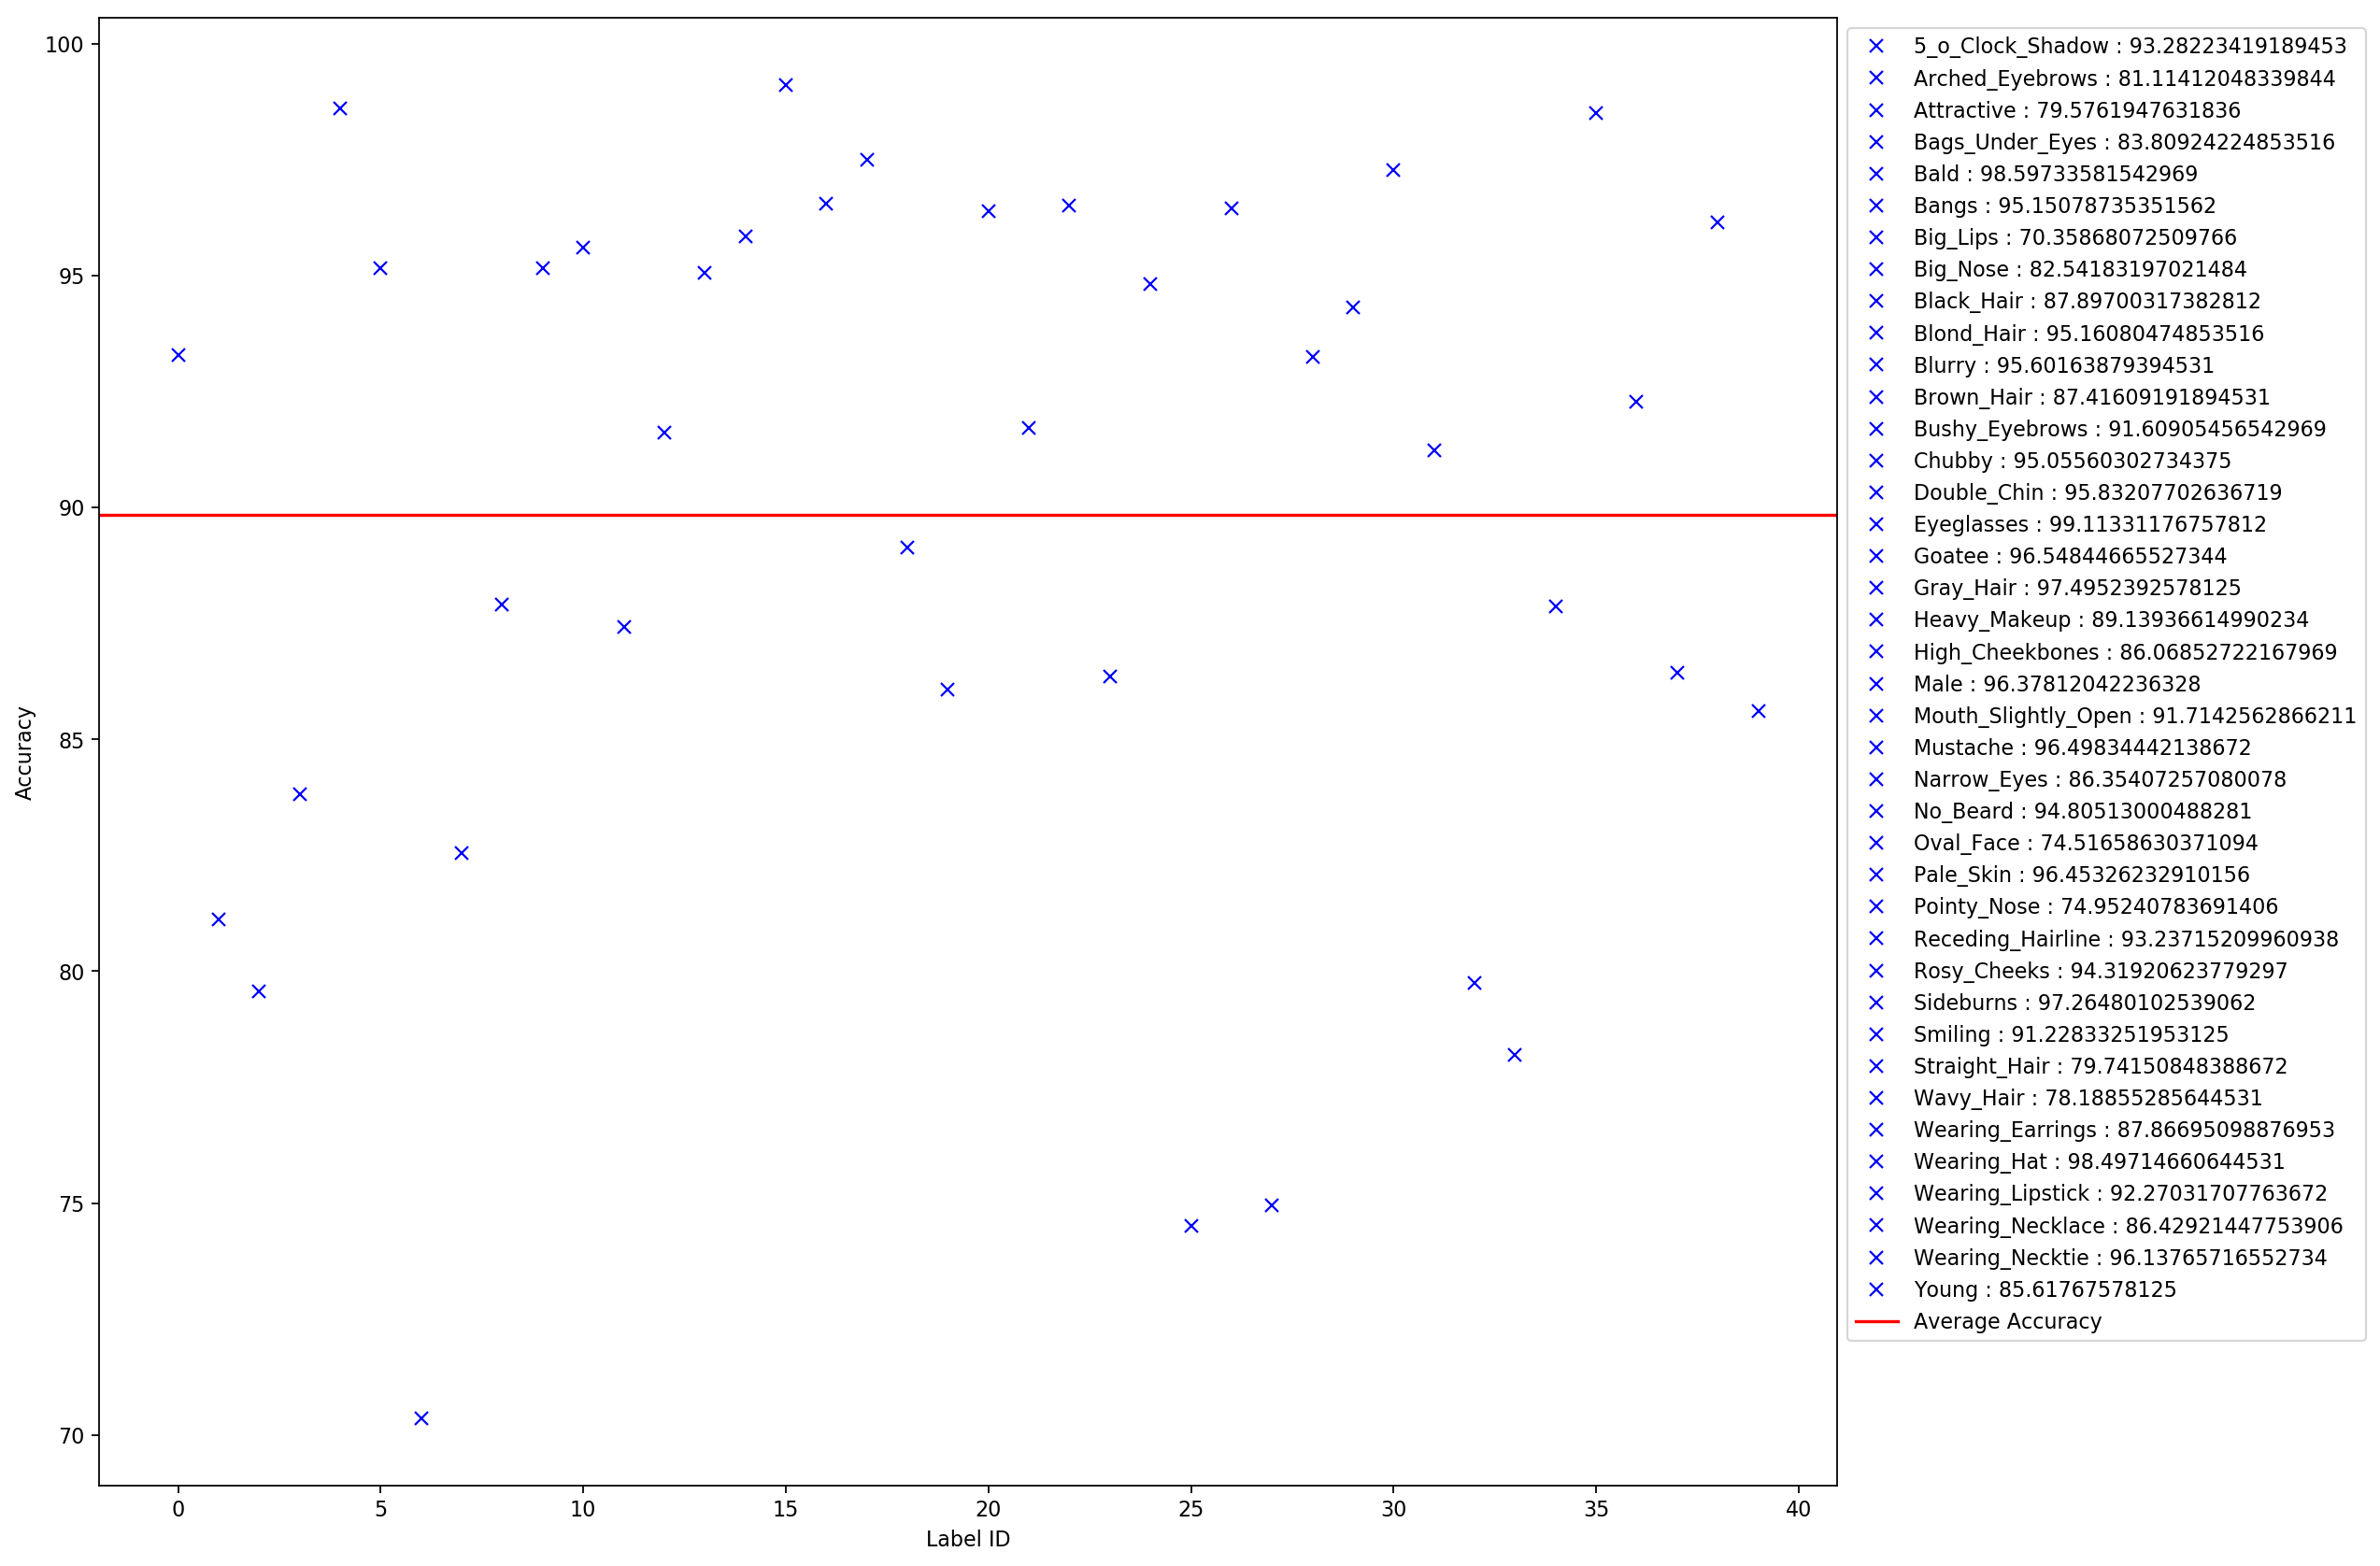

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import json

plt.figure(figsize=(15, 13), dpi= 80, facecolor='w', edgecolor='k')

for idx, score in enumerate(class_accuracies):
    plt.plot(idx,score, 'bx', label=f"{label_ids[idx]} : {score}")

plt.axhline(y=100 * correct / total, color='r', linestyle='-', label='Average Accuracy')
#plt.legend(frameon=False, loc='lower center', ncol=2)
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1), ncol=1)
plt.xlabel('Label ID')
plt.ylabel('Accuracy')

plt.show()

### Plot the accuracy and loss trends during training and validation 

#### Loss Graph

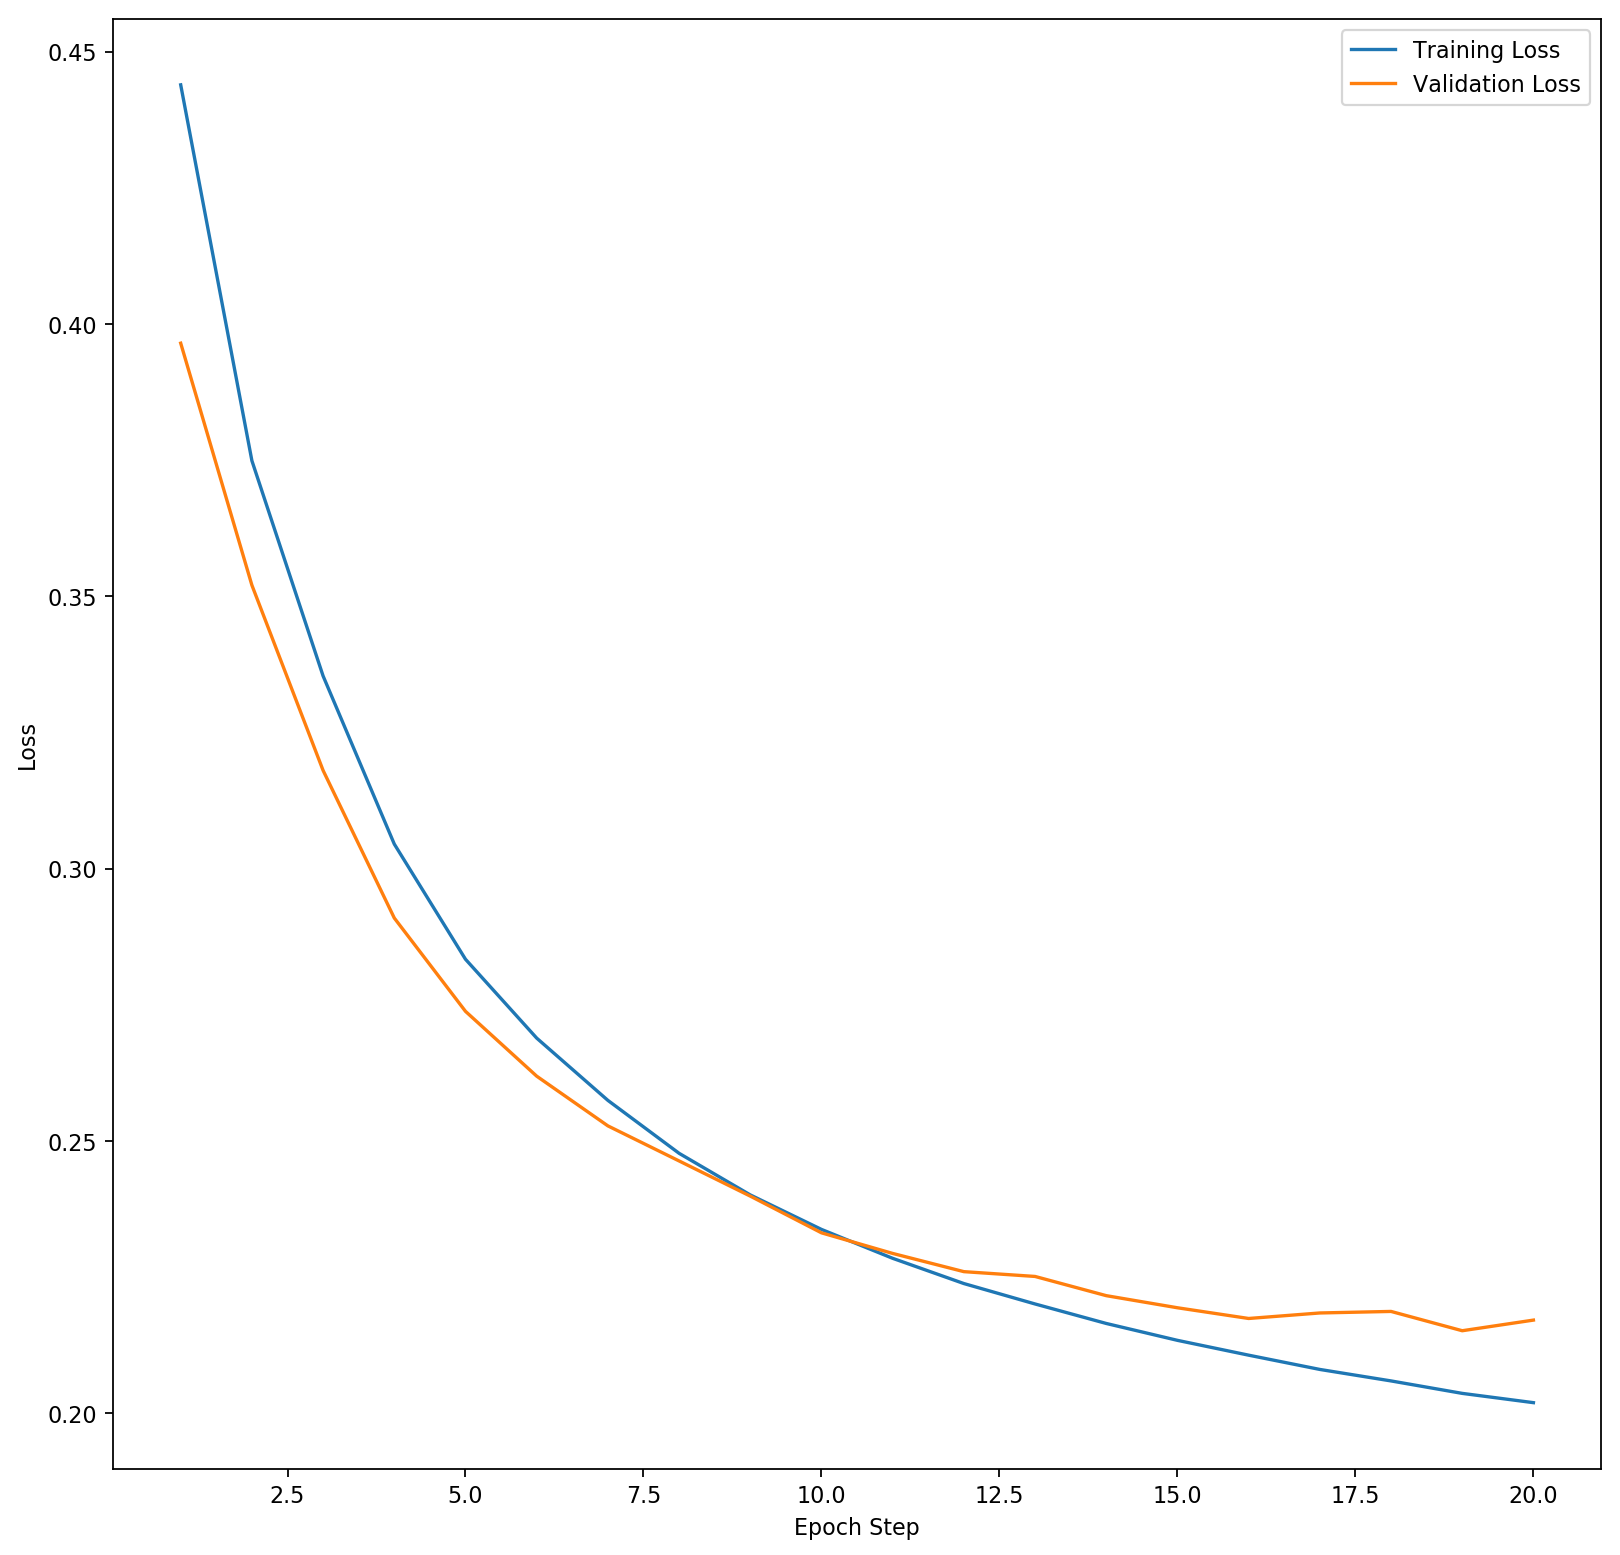

In [6]:
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')

with open('models/metrics.json', 'r') as handle:
    metrics = json.load(handle)
x_axis = list(range(1,21))    
plt.plot(x_axis, metrics['train_loss'], label='Training Loss')
plt.plot(x_axis, metrics['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
plt.show()

#### Accuracies Graph

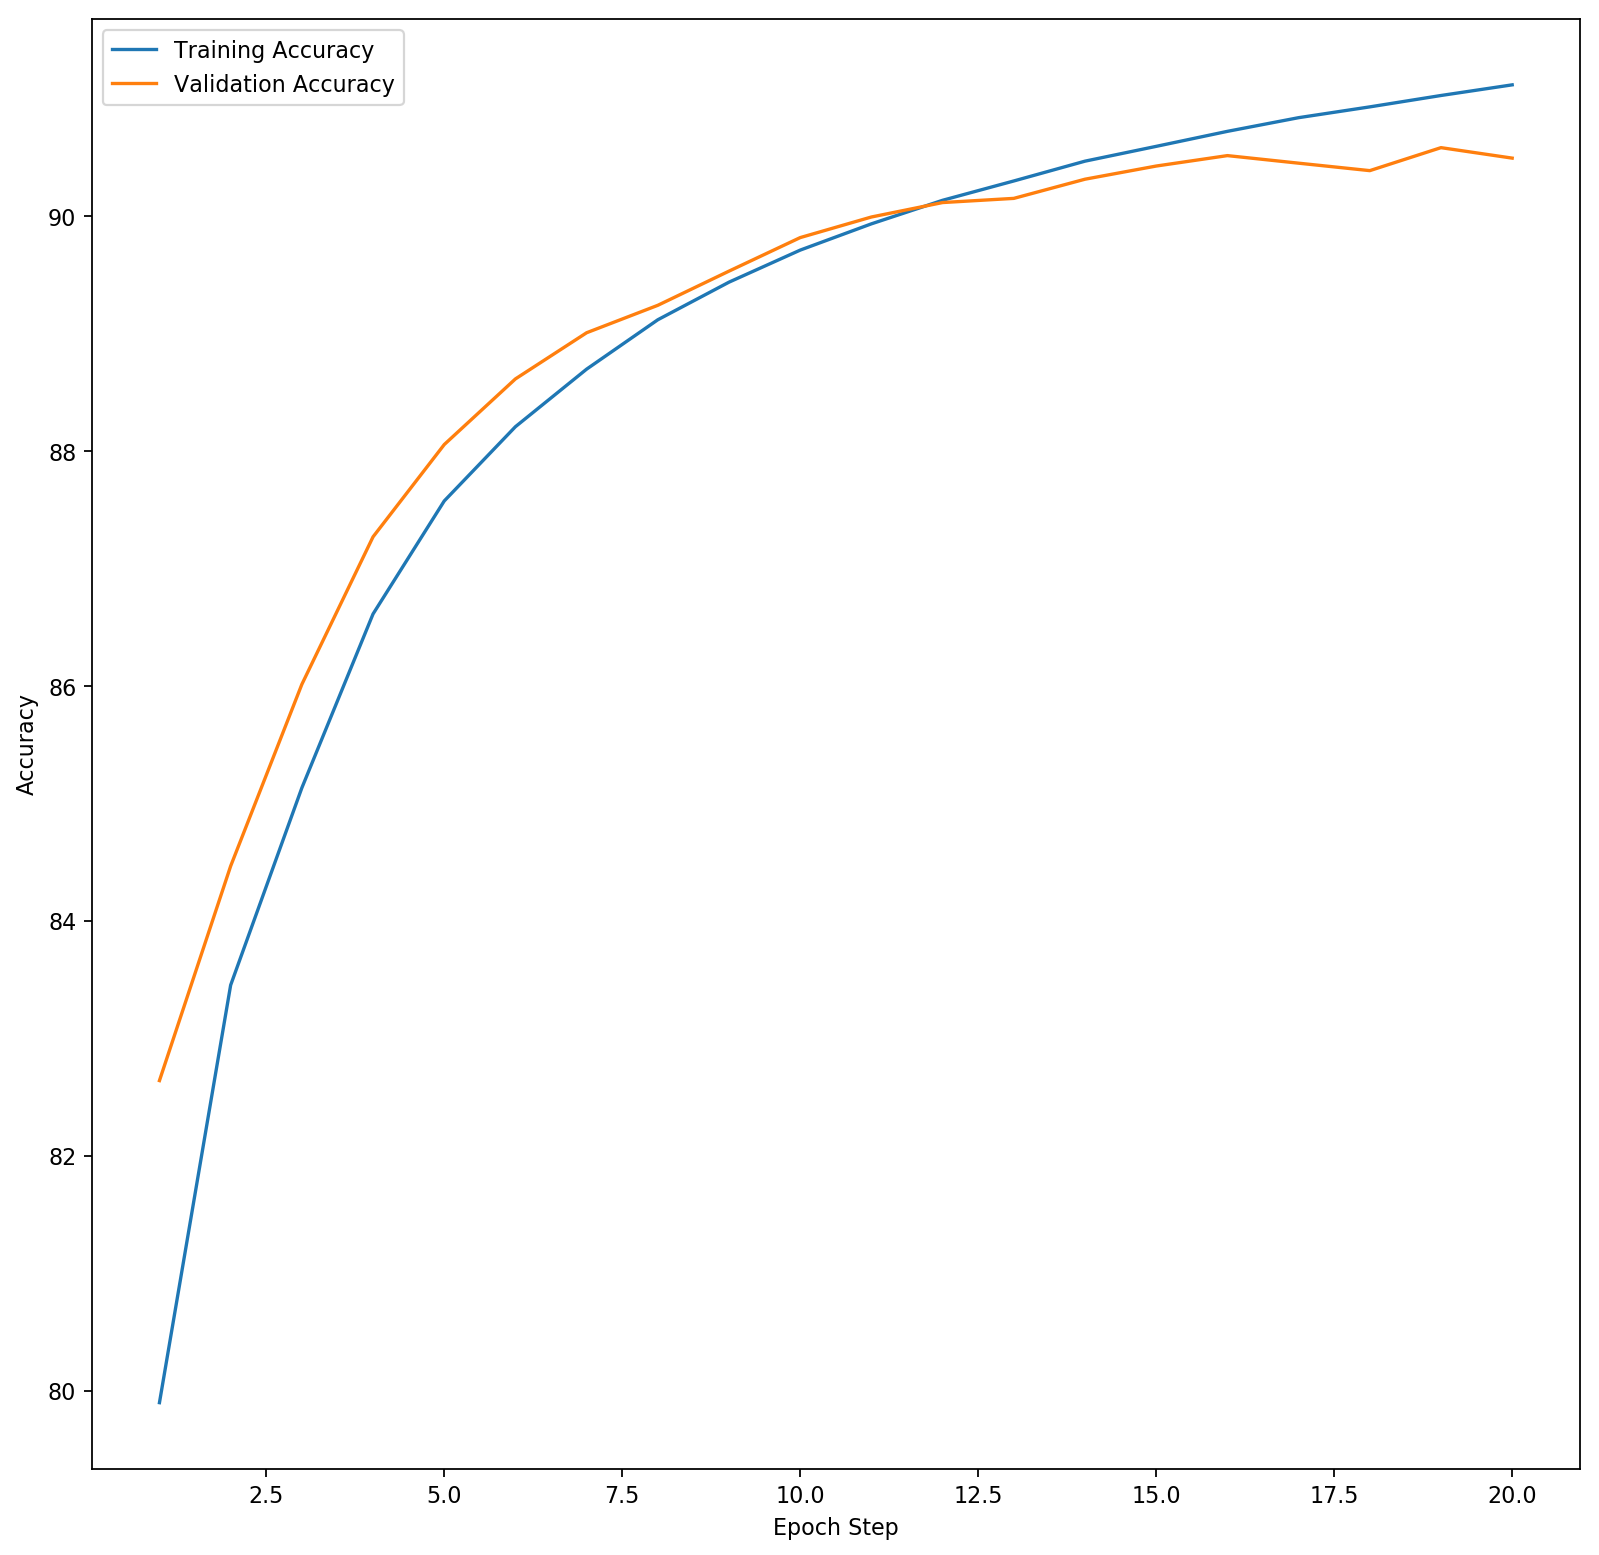

In [7]:
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(x_axis, metrics['train_accuracy'], label='Training Accuracy')
plt.plot(x_axis, metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch Step')
plt.ylabel('Accuracy')
plt.show()